In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
data=pd.read_csv('../Data/data.csv')

In [3]:
#select features only
x=data.drop(['id','diagnosis','Unnamed: 32'],axis=1)
y=data['diagnosis']

In [4]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Feature Selection using Correlation

The simplest method for feature selection is correlation between independent variables. Most ML models perform well when they are trained on only important features and for our case, we have 30 exploratory features. Using correlation coefficients, we can assume that variables with high correlation are redundant t a model and remain with any (arbitrary) on among them.

<AxesSubplot:>

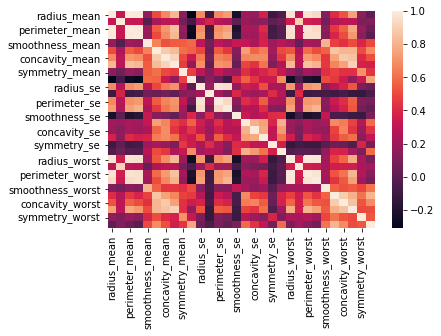

In [5]:
sns.heatmap(x.corr())

In [6]:
corr=x.corr()

In [7]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [8]:
# Selected column
cols_pass=x.columns[columns].to_list()
cols_dropped=x.columns[~columns].to_list()

In [9]:
print('Number of selected cols: {}'.format(len(cols_pass)))
cols_pass

Number of selected cols: 20


['radius_mean',
 'texture_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [10]:
print('Number of removed cols: {}'.format(len(cols_dropped)))
cols_dropped

Number of removed cols: 10


['perimeter_mean',
 'area_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

By removing columns which are highly correlated (>=0.9, which is very high correlation usualy), we remain with 20 features

#### Tree based feature selection and random forest classification

In [11]:
x_new=x[cols_pass]

In [12]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
def random_forest_fimportance(x_train,y_train):
    clf_rf_5 = RandomForestClassifier()      
    clr_rf_5 = clf_rf_5.fit(x_train,y_train)
    importances = clr_rf_5.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest

    plt.figure(1, figsize=(14, 7))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices])
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()
    
    return clf_rf_5

Feature ranking:
1. feature 27 (0.159931)
2. feature 23 (0.134087)
3. feature 22 (0.106406)
4. feature 20 (0.099980)
5. feature 7 (0.089940)
6. feature 6 (0.060071)
7. feature 26 (0.042748)
8. feature 13 (0.041391)
9. feature 0 (0.041225)
10. feature 2 (0.033055)
11. feature 3 (0.028354)
12. feature 21 (0.020690)
13. feature 24 (0.015154)
14. feature 25 (0.014590)
15. feature 5 (0.013999)
16. feature 1 (0.013868)
17. feature 10 (0.013482)
18. feature 28 (0.008805)
19. feature 16 (0.007052)
20. feature 15 (0.006561)
21. feature 19 (0.006329)
22. feature 9 (0.005751)
23. feature 12 (0.005676)
24. feature 4 (0.005547)
25. feature 29 (0.005272)
26. feature 18 (0.004653)
27. feature 11 (0.004361)
28. feature 8 (0.004101)
29. feature 17 (0.003852)
30. feature 14 (0.003068)


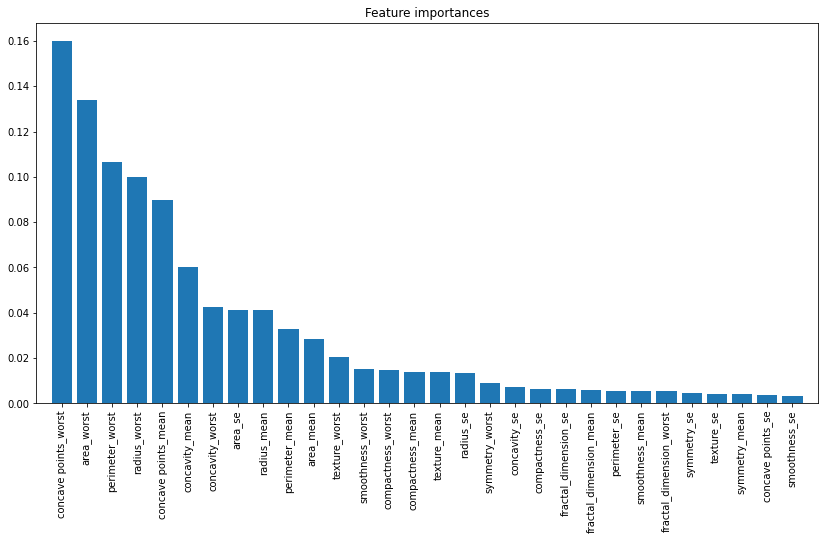

In [14]:
rf_model1=random_forest_fimportance(x_train,y_train)

Accuracy is:  0.956140350877193


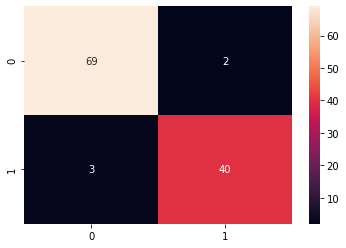

In [15]:
acc_score = accuracy_score(y_test,rf_model1.predict(x_test))
print('Accuracy is: ',acc_score)
confusion_mat = confusion_matrix(y_test,rf_model1.predict(x_test))
_=sns.heatmap(confusion_mat,annot=True,fmt="d")

In [16]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_new, y, test_size=0.2, random_state=42)

Feature ranking:
1. feature 0 (0.209276)
2. feature 4 (0.167098)
3. feature 17 (0.122490)
4. feature 7 (0.080474)
5. feature 3 (0.064699)
6. feature 16 (0.051837)
7. feature 1 (0.048189)
8. feature 18 (0.036504)
9. feature 11 (0.030602)
10. feature 15 (0.023149)
11. feature 6 (0.023040)
12. feature 2 (0.022928)
13. feature 12 (0.019263)
14. feature 10 (0.019181)
15. feature 14 (0.018376)
16. feature 13 (0.015551)
17. feature 19 (0.013128)
18. feature 9 (0.012844)
19. feature 5 (0.012042)
20. feature 8 (0.009328)


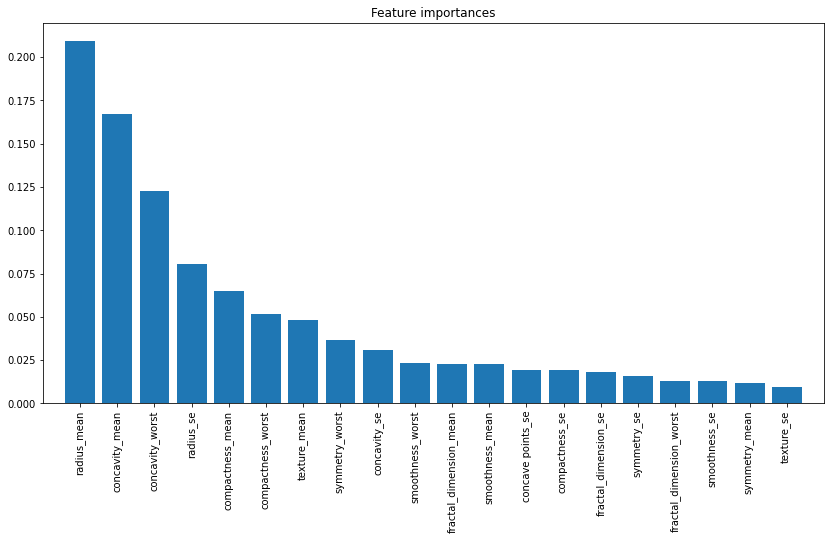

In [17]:
rf_model2=random_forest_fimportance(x_train1,y_train1)

Accuracy is: 0.9649122807017544


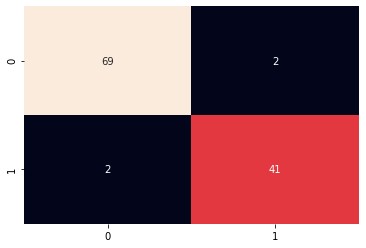

In [18]:
acc_score1 = accuracy_score(y_test1,rf_model2.predict(x_test1))
print('Accuracy is: {}'.format(acc_score1))
confusion_mat1 = confusion_matrix(y_test1,rf_model2.predict(x_test1))
_=sns.heatmap(confusion_mat1,annot=True,fmt="d",cbar=False)

By using confusion matrix accuracy score, we can see that the RF with 20 features actually has more accuracy that the model with 30 features